## 1.Data Exploration


In [1]:
#import necessary libraries
import re
import pandas as pd
import nltk
import csv
import numpy as np
import seaborn as sns
from tqdm import tqdm
tqdm.pandas()
from nltk.corpus import stopwords
pd.set_option('display.max_colwidth', None)
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

In [2]:
def explore_dataset(input_dir,file):
    df= pd.read_csv(input_dir+"/"+file)
    df.loc[df["label"] == False, "label"] = 0 #anomaly
    df.loc[df["label"] == True, "label"] = 1 #non_anomaly
    df.dropna(inplace=True)
    print("This file consists of {} log files".format(df.shape[0]))
    print("The number of unique logs in the text field is: " + str(df['text'].nunique()))
    plt.figure(figsize=(3, 4), dpi = 110)
    imbalanced_data_plot= sns.countplot(x=df['label'])
    return df,imbalanced_data_plot   

This file consists of 393433 log files
The number of unique logs in the text field is: 83188


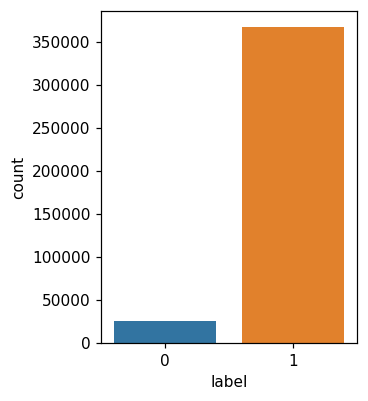

In [3]:
input_dir="output"
file="Hadoop.csv"

hadoop_df,plot=explore_dataset(input_dir,file)

In [4]:
hadoop_df.head()

,timestamp,text,label
0,1.445121e+12,INFO [main] org.apache.hadoop.metrics2.impl.MetricsConfig: loaded properties from hadoop-metrics2.properties,0
1,1.445121e+12,INFO [main] org.apache.hadoop.metrics2.impl.MetricsSystemImpl: Scheduled snapshot period at 10 second(s).,0
2,1.445121e+12,INFO [main] org.apache.hadoop.metrics2.impl.MetricsSystemImpl: MapTask metrics system started,0
3,1.445121e+12,INFO [main] org.apache.hadoop.mapred.YarnChild: Executing with tokens:,0
4,1.445121e+12,"INFO [main] org.apache.hadoop.mapred.YarnChild: Kind: mapreduce.job, Service: job_1445062781478_0011, Ident: (org.apache.hadoop.mapreduce.security.token.JobTokenIdentifier@56b87a95)",0


## 2.Feature Extraction

Steps to follow:
1. Split data into training and testing to avoid data leakage
2. Run X_train and X_test through the vectorizer to obtain tfidf values

In [13]:
def train_test_vectorize(df):
    training_data,testing_data = train_test_split(df, test_size=0.2, random_state=0)

    
    X_train_unprocessed=training_data['text']
    y_train=training_data['label']
    y_train=y_train.astype('int')

    X_test_unprocessed=testing_data['text']
    y_test=testing_data['label']
    y_test=y_test.astype('int')

    tfidf_vectorizer = TfidfVectorizer()
    
    vectorized_text_train=tfidf_vectorizer.fit_transform(X_train_unprocessed)
    vectorized_text_test=tfidf_vectorizer.fit_transform(X_test_unprocessed)
    
    return vectorized_text_train,y_train,vectorized_text_test,y_test

In [14]:
X_train,y_train,X_test,y_test=train_test_vectorize(hadoop_df)

In [15]:
X_train

<314746x25434 sparse matrix of type '<class 'numpy.float64'>'
	with 4060981 stored elements in Compressed Sparse Row format>

In [16]:
def simple_logistic_regression(X_train, y_train, X_test, y_test):
    
    clf = LogisticRegression(random_state=0).fit(X_train, y_train)
    pred=clf.predict(X_test)
    return pred

In [ ]:
simple_logistic_regression(X_train, y_train, X_test, y_test)

After a failed attempt to run the logistic regression, I hoped that normalizing the data or reducing the feature space might prove helpful. However, I have not been successul at this either.

In [4]:

def normalize_and_pca(df,text, lines = -1,keep_stopwords = True):
    """Normalizes text in to lower capital letters, removes non-alpha numeric characters,
    new lines, stopwords from the original text"""
    
    # 1. Normalize text: 
    if keep_stopwords:
        df['norm_text'] = (df[text]
                .progress_apply(lambda x: x.lower())                             #lower text
                .progress_apply(lambda y: re.sub('[\W+\d+]', " ", y))            #remove non-alpha numeric charcaters
                .progress_apply(lambda z: re.sub('\n',"", z))                    #remove new line
                .progress_apply(lambda d: re.sub('__',"",d))                     #remove double underscore
                .progress_apply(lambda sd: re.sub('_',"",sd))                    #remove single underscore
                .progress_apply(lambda rs: " ".join(rs.split())))                #remove extra spaces   
        
  
    # 2. Vectorize text
    
    # keep max_features 500
    # initiate vectorizer: 
    vectorizer  = TfidfVectorizer(max_features=500)
    
    if lines>=0:
        norm_text = df['norm_text'].values[0:lines]
    else: 
        norm_text = df['norm_text'].values

    # fit transform
    X = vectorizer.fit_transform(norm_text)
    
    # convert vectorized text into dataframe
    df_x_tdif = pd.DataFrame(X.toarray(), columns = vectorizer.get_feature_names_out())
    
    
    # 3. Reduce TFIDF features X, to 6 Principle components (Assessing impact)
    
    from sklearn.decomposition import PCA
    
    X_pca = PCA(n_components=6).fit_transform(StandardScaler().fit_transform(df_x_tdif))
    
    # convert pca features to dataframe:
    df_xpca = pd.DataFrame(X_pca, columns = ["pca"+str(i) for i in range(1, npca_components+1)])
    
    # concat df_pca features with df
    df_pca = pd.concat([df, df_xpca], axis = 1, ignore_index=False)

    # 4. Return output 
    # df with reduced pca features
    # df with vectorized text
    
    return df_pca, df_x_tdif

In [ ]:
normalize_pca(hadoop_df,'text', lines = -1,keep_stopwords = True)

100%|██████████| 393433/393433 [00:00<00:00, 823904.03it/s]
